<a href="https://colab.research.google.com/github/waelrash1/forecastingmodelsPY/blob/main/CH10/CH10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Forecasting multiple time series

* Examining the VAR model
* Exploring Granger causality to validate the use of the VAR model
* Forecasting multiple time series using the VAR model


* SARIMAX model can be used to include the impact of exogenous variables on a time series.
* With the SARIMAX model, the relationship is unidirectional: we assume that the exogenous variable has an impact on the target only.
* However, it is possible that two time series have a bidirectional relationship,
> meaning that time series t1 is a predictor of time series t2, and time series t2 is also a predictor for time series t1.
* This brings us to the vector autoregression (VAR) model.

## Examining the VAR model
* The vector autoregression (VAR) model captures the relationship between multiple series as they change over time.
* In this model, each series has an impact on the other, unlike the SARIMAX model where the exogenous variable had an impact on the target, but not the other way around.
* VAR model can be seen as a generalization of the $AR(p)$ model to allow for the forecast of multiple time series.
* Therefore, we can also denote the VAR model as $VAR(p)$, where $p$ is the order and hasthe same meaning as in the $AR(p)$ model.


## Examining the VAR model cont.
* Recall that $AR(p)$:

$$
\Large y_t= C+ \phi_1 y_{t-1}+\phi_2 y_{t-2}+...+\phi_p y_{t-p}+\epsilon_t
$$


## Examining the VAR model cont.
* For simplicity, let’s consider a system with two time series, denoted as y1,t and y2,t, and an order of 1, meaning that p = 1. Then, using matrix notation, the VAR(1) model can be expressed as

$$
\Large \begin{bmatrix}
y_{1,t}\\
y_{2,t}
\end{bmatrix} =\begin{bmatrix}
C_{1}\\
C_{2}
\end{bmatrix}+ \begin{bmatrix}
\phi_{1,1}, \phi_{1,2}\\
\phi_{2,1}, \phi_{2,2}
\end{bmatrix}\begin{bmatrix}
y_{1,t-1}\\
y_{2,t-1}
\end{bmatrix} + \begin{bmatrix}
\epsilon_{1,t}\\
\epsilon_{2,t}
\end{bmatrix}
$$

## Vector autoregression model
* The vector autoregression model VAR(p) models the relationship of two or more time series. In this model, each time series has an impact on the others.
* This means that past values of one time series affect the other time series, and vice versa.
* The VAR(p) model can be seen as a generalization of the AR(p) model that allows for multiple time series. Just like in the AR(p) model, the order p of the VAR(p) model determines how many lagged values impact the present value of a series.
* In this model, however, we also include lagged values of other time series.

* For two time series, the general equation for the VAR(p) model is a linear combination of a vector of constants, past values of both time series, and a vector of error terms:
* Note that the time series must be stationary to apply the VAR model.


$$
\Large \begin{bmatrix}
y_{1,t}\\
y_{2,t}
\end{bmatrix} =\begin{bmatrix}
C_{1}\\
C_{2}
\end{bmatrix}+ \begin{bmatrix}
\phi_{1,1}^1, \phi_{1,2}^1\\
\phi_{2,1}^1, \phi_{2,2}^1
\end{bmatrix}\begin{bmatrix}
y_{1,t-1}\\
y_{2,t-1}
\end{bmatrix} + \begin{bmatrix}
\phi_{1,1}^2, \phi_{1,2}^2\\
\phi_{2,1}^2, \phi_{2,2}^2
\end{bmatrix}\begin{bmatrix}
y_{1,t-2}\\
y_{2,t-2}
\end{bmatrix} +...+ \begin{bmatrix}
\phi_{1,1}^p, \phi_{1,2}^p\\
\phi_{2,1}^p, \phi_{2,2}^p
\end{bmatrix}\begin{bmatrix}
y_{1,t-p}\\
y_{2,t-p}
\end{bmatrix} +\begin{bmatrix}
\epsilon_{1,t}\\
\epsilon_{2,t}
\end{bmatrix}
$$

## Real consumption and real disposable income
* This time we’ll explore the relationship between real disposable income and real consumption.
> Real consumption expresses how much money people spend, while real disposable
income represents how much money is available to spend. Therefore, it is a reason-
able hypothesis that a higher amount of disposable income could signal higher con-
sumption. The opposite can also be true, with higher consumption meaning that more income is available for spending. This bidirectional relationship can be captured by a
VAR model.

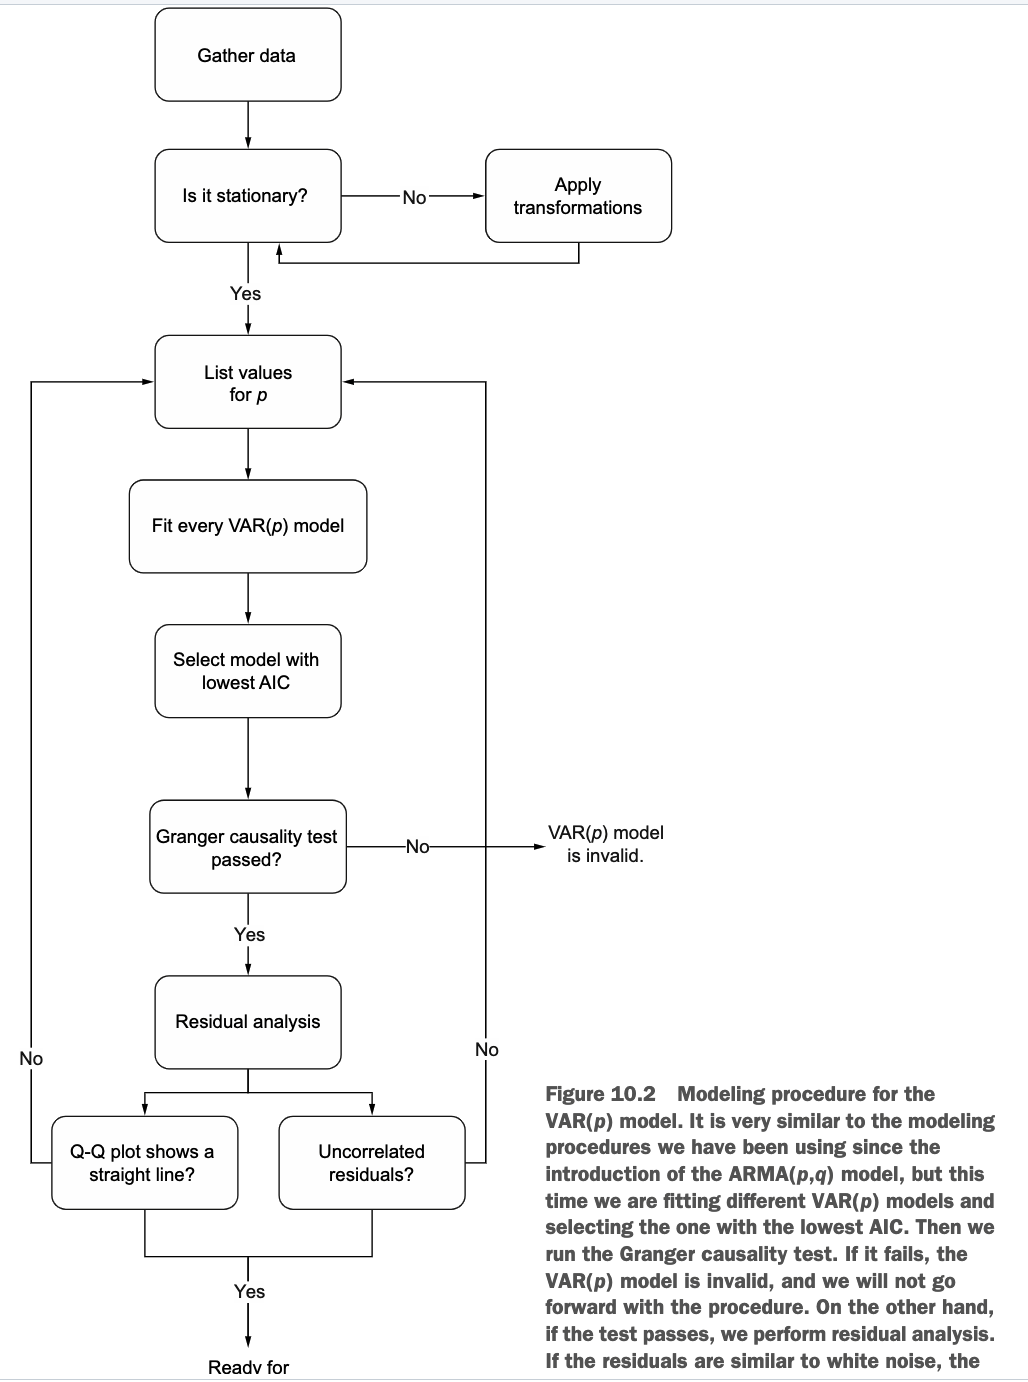

In [1]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


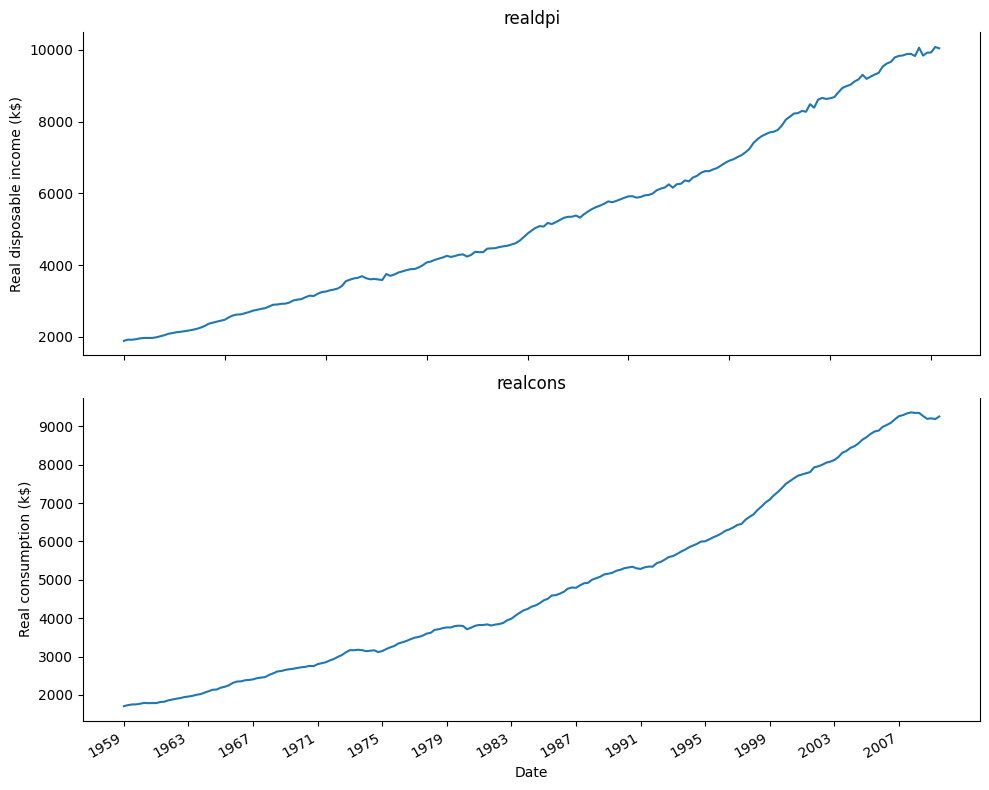

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)

ax2.plot(macro_econ_data['realcons'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH10_F01_peixeiro.png', dpi=300)

# VAR

## 1- Test Stationarity

In [5]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: 2.986025351954683
p-value: 1.0

---------------------

realcons
ADF Statistic: 1.549912338050964
p-value: 0.9976992503412904


> Not-stionary and need to apply difference.

# VAR

## 2- Transformation
* Apply time series difference
* Test the stationarity using ADFuler test


In [6]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'].diff()[1:])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: -8.864893340673007
p-value: 1.4493606159108096e-14

---------------------

realcons
ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571


# VAR

## 3- Train VARMAX model

In [47]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.varmax import VARMAX

def optimize_VAR(train) -> pd.DataFrame:

    results = []

    for i in tqdm_notebook(range(9)):
        try:
            model = VARMAX(train, order=(i, 0), verbose=False).fit(dips=False)
        except:
            continue

        aic = model.aic
        results.append([i, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [48]:
endog = macro_econ_data[['realdpi', 'realcons']]

endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

train = endog_diff[:162]
test = endog_diff[162:]

result_df = optimize_VAR(train)
result_df

  0%|          | 0/9 [00:00<?, ?it/s]

,p,AIC
0,3,3123.070078
1,5,3123.708523
2,6,3126.855598
3,4,3129.194047
4,2,3130.091668
5,7,3133.398275
6,1,3134.333343
7,8,3137.149013


In [9]:
result_df

,p,AIC
0,3,3123.070078
1,5,3123.708523
2,6,3126.855598
3,4,3129.194047
4,2,3130.091668
5,7,3133.398275
6,1,3134.333343
7,8,3137.149013


In [39]:
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


In [41]:
best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                          VARMA(3,2)   Log Likelihood               -1537.748
                               + intercept   AIC                           3125.495
Date:                     Mon, 15 Apr 2024   BIC                           3202.685
Time:                             12:17:24   HQIC                          3156.835
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.31   Jarque-Bera (JB):          79.03, 6.07
Prob(Q):                        0.93, 0.58   Prob(JB):                   0.00, 0.05
Heteroskedasticity (H):         3.81, 3.75   Skew:                      0.28

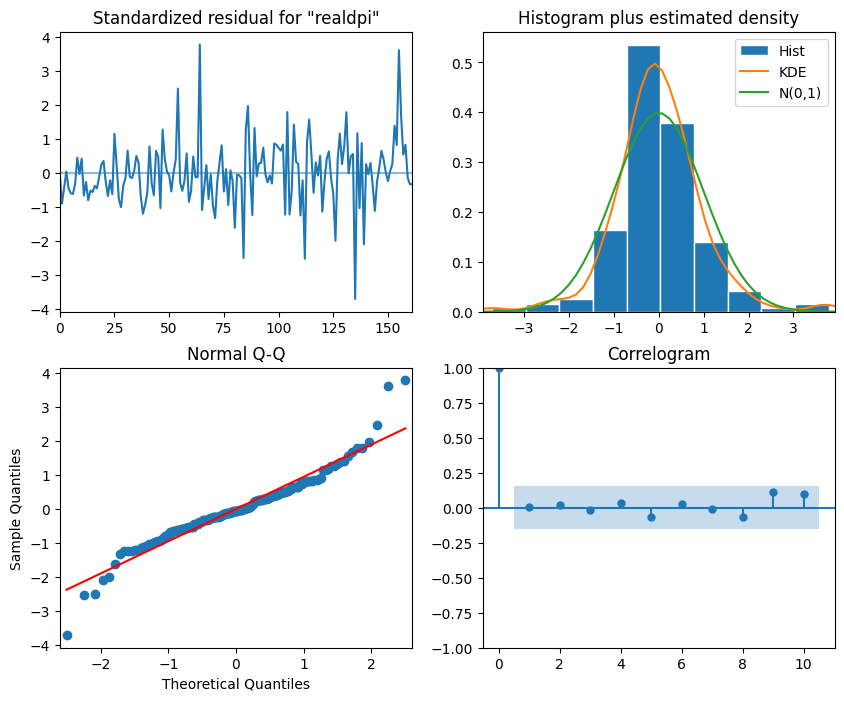

In [42]:
# realdpi
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

plt.savefig('figures/CH10_F04_peixeiro.png', dpi=300)

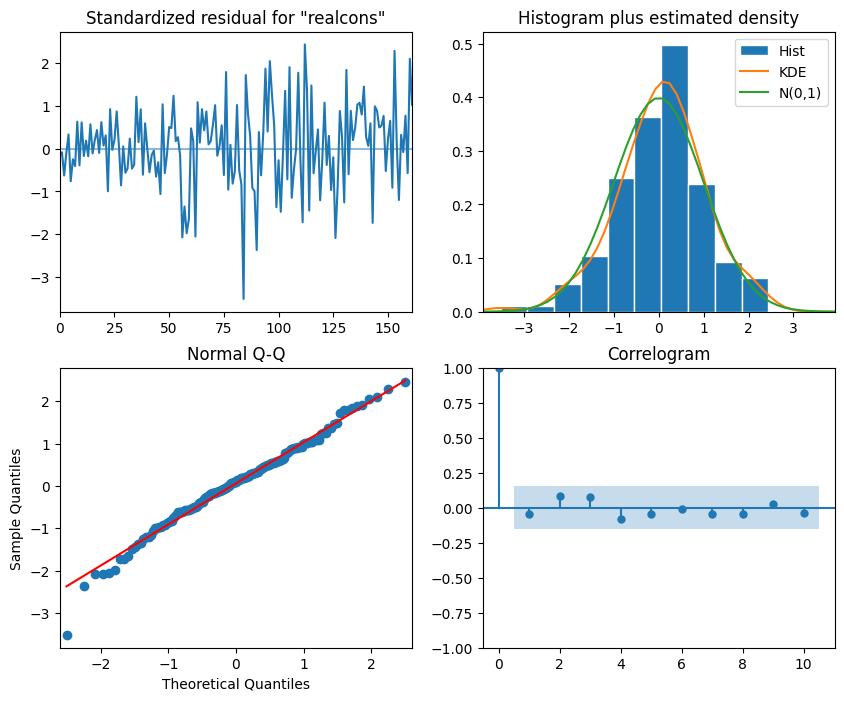

In [43]:
# realcons
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

plt.savefig('figures/CH10_F05_peixeiro.png', dpi=300)

In [44]:
realgdp_residuals = best_model_fit.resid['realdpi']

acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))



,lb_stat,lb_pvalue
1,0.011809,0.913467
2,0.092445,0.954829
3,0.117983,0.989595
4,0.280647,0.991029
5,1.021564,0.960808
6,1.128355,0.980276
7,1.155788,0.991909
8,1.950360,0.982496
9,4.036607,0.908987
10,5.724940,0.837819


In [45]:
realcons_residuals = best_model_fit.resid['realcons']

acorr_ljungbox(realcons_residuals, np.arange(1, 11, 1))



,lb_stat,lb_pvalue
1,0.262659,0.608299
2,0.959717,0.618871
3,0.967606,0.809090
4,1.141463,0.887639
5,1.246330,0.940356
6,1.321659,0.970450
7,1.580602,0.979387
8,1.977910,0.981682
9,2.423625,0.982867
10,2.442593,0.991686


In [46]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'VAR':

        realdpi_pred_VAR = []
        realcons_pred_VAR = []

        for i in tqdm_notebook(range(train_len, total_len, window)):
            model = VARMAX(df[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)

            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']

            realdpi_pred_VAR.extend(oos_pred_realdpi)
            realcons_pred_VAR.extend(oos_pred_realcons)

        return realdpi_pred_VAR, realcons_pred_VAR

    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []

        for i in range(train_len, total_len, window):

            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']

            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))

        return realdpi_pred_last, realcons_pred_last

In [29]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VAR, realcons_pred_VAR = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')

  0%|          | 0/10 [00:00<?, ?it/s]

In [30]:
test = endog[163:]

test['realdpi_pred_VAR'] = pd.Series()
test['realdpi_pred_VAR'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR)

test['realcons_pred_VAR'] = pd.Series()
test['realcons_pred_VAR'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VAR)

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR
163,7887.7,7389.2,7829.224941,7354.323079
164,8053.4,7501.3,7897.190077,7430.252000
165,8135.9,7571.8,7960.564871,7496.624306
166,8222.3,7645.9,8014.757071,7556.606726
167,8234.6,7713.5,8080.701763,7630.989437
168,8296.5,7744.3,8142.391377,7692.838219
169,8273.7,7773.5,8200.122120,7753.858671
170,8484.5,7807.7,8259.360845,7812.527390
171,8385.5,7930.0,8264.384832,7864.627994
172,8611.6,7957.3,8320.857168,7895.052746


In [32]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.224941,7354.323079,7716.0,7199.9
164,8053.4,7501.3,7897.190077,7430.252000,7716.0,7199.9
165,8135.9,7571.8,7960.564871,7496.624306,7716.0,7199.9
166,8222.3,7645.9,8014.757071,7556.606726,7716.0,7199.9
167,8234.6,7713.5,8080.701763,7630.989437,8135.9,7571.8
168,8296.5,7744.3,8142.391377,7692.838219,8135.9,7571.8
169,8273.7,7773.5,8200.122120,7753.858671,8135.9,7571.8
170,8484.5,7807.7,8259.360845,7812.527390,8135.9,7571.8
171,8385.5,7930.0,8264.384832,7864.627994,8273.7,7773.5
172,8611.6,7957.3,8320.857168,7895.052746,8273.7,7773.5


Exception ignored in: <function tqdm.__del__ at 0x7c02e5d5c9d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/lib/python3.10/dist-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


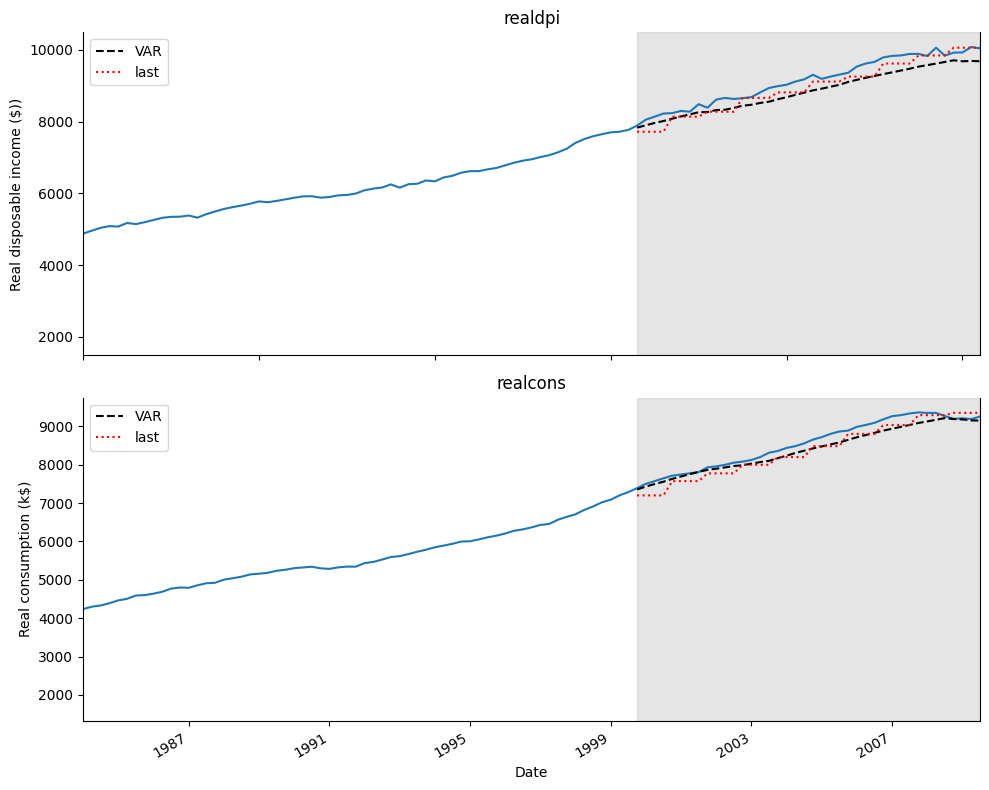

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VAR'], 'k--', label='VAR')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(100, 202)
ax1.legend(loc=2)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VAR'], 'k--', label='VAR')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(100, 202)
ax2.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(100, 202)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH10_F06_peixeiro.png', dpi=300)

In [34]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [35]:
mape_realdpi_VAR = mape(test['realdpi'], test['realdpi_pred_VAR'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VAR = mape(test['realcons'], test['realcons_pred_VAR'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

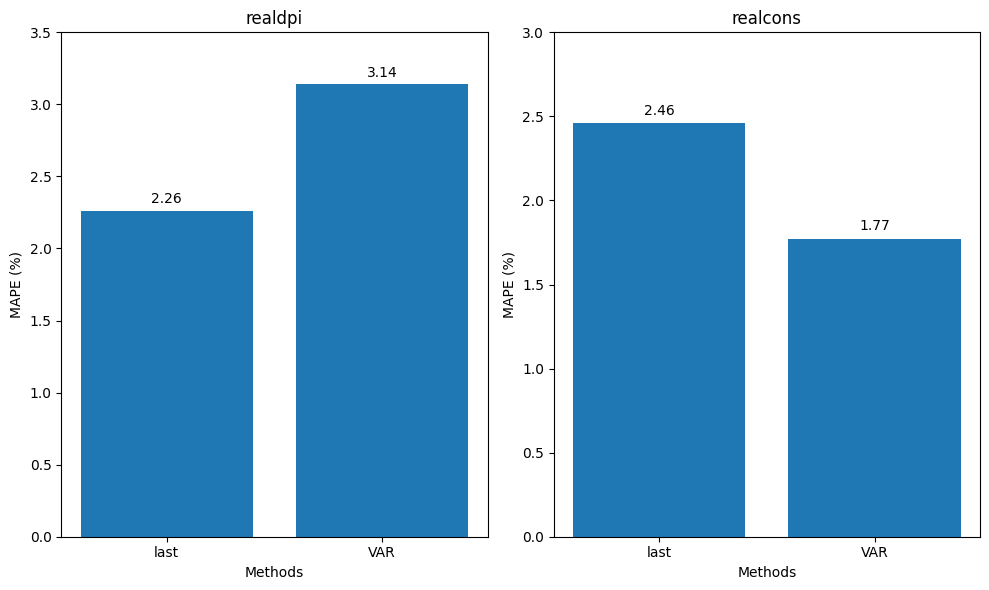

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR']
y1 = [mape_realdpi_last, mape_realdpi_VAR]
y2 = [mape_realcons_last, mape_realcons_VAR]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH10_F07_peixeiro.png', dpi=300)